**UNET- Semantic Segmentation Model Training Implementation**

**Step 1:** Configure Dataset Filepaths

In [7]:
import os
import glob

# Replace the "home/username/dev/" with your own directory path

work_dir= "/home/aazam/dev" + "/Visual-Saliency-Prediction-UNET-Model/"
# Verify image paths
if not os.path.exists(work_dir):
    print(f"Path does not exist: {work_dir}")
else:
    print(f"Path exists: {work_dir}")

    # Create lists of image and mask file paths
    image_paths = glob.glob(work_dir + 'Dataset/Images/*.png')
    mask_paths = glob.glob(work_dir + 'Dataset/Masks/*.png')
    print('Total Images in Dataset:', len(image_paths))

Path exists: /home/aazam/dev/Visual-Saliency-Prediction-UNET-Model/
Total Images in Dataset: 13426


**Step 2:** Segregate datasets to three batches sets (Training Set, Cross-Validation Set & Testing Set)

In [26]:
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split


# Resizing images is optional, since dataset is 256x256
SIZE_X = 128
SIZE_Y = 128

# Split the data into training and remaining sets (60% for training, 40% for validation and testing)
image_train, image_remaining, mask_train, mask_remaining = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)

# Split the remaining data into validation and test sets (20% each)
image_valid, image_test, mask_valid, mask_test = train_test_split(image_remaining, mask_remaining, test_size=0.5, random_state=42)

print('Splitting Datasets Files & Creating Tensorflow Datasets for each:')
print('Total Dataset Files:', len(image_paths),
      '\nTraining Files (60%):', len(image_train),
      '\nValidation Dataset (20%):', len(image_valid),
      '\nTest Dataset Files (20%):', len(image_test)
       )

# Define the dataset loading and preprocessing function
def load_and_preprocess_images_masks(image_path, mask_path):
    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (SIZE_X, SIZE_Y))
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Load and preprocess mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (SIZE_X, SIZE_Y))
    mask = tf.math.round(mask / 255.0)

    return image, mask

# Create TensorFlow datasets for training, validation, and testing
dataset_train = tf.data.Dataset.from_tensor_slices((image_train, mask_train))
dataset_train = dataset_train.map(load_and_preprocess_images_masks)
dataset_train = dataset_train.shuffle(buffer_size=len(image_train)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((image_valid, mask_valid))
dataset_valid = dataset_valid.map(load_and_preprocess_images_masks)
dataset_valid = dataset_valid.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


Total Images: 13426
Splitting Datasets Files & Creating Tensorflow Datasets for each:
Total Dataset Files: 13426 
Training Files (60%): 9398 
Validation Dataset (20%): 2014 
Test Dataset Files (20%): 2014


In [28]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)

# # Place tensors on the CPU
# with tf.device('/CPU:0'):
#     a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#     b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# c = tf.matmul(a, b)
# print(c)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


Num GPUs Available:  0


**Step 3:** Train & Validate the Unet Model

In [18]:
import os
# Set the SM_FRAMEWORK environment variable to 'tf.keras', indicating that we want to use TensorFlow's Keras API for training our model:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.optimizers import Adam
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

# Assuming you have the datasets: dataset_train, dataset_valid, and dataset_test
# Model Name
trainedmodel_path = drive_dir + 'Trained Models/'
os.makedirs(trainedmodel_path, exist_ok=True)

modelname = 'unetmodel_v'+str(len(glob.glob(trainedmodel_path + '/*.h5')))+'.h5'
modelpath = drive_dir + 'Trained Models/'+ modelname
logpath = drive_dir+'Logs'
# Define U-Net model using segmentation_models library
def unet_model(input_shape):
    model = Unet(backbone_name='resnet34', input_shape=input_shape, encoder_weights='imagenet', classes=1, activation='sigmoid')
    model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])
    return model

# Define model
input_shape = (SIZE_X, SIZE_Y, 3)  # Adjust based on the size of your images
model = unet_model(input_shape)

# Model Checkpoint - save model after every epochs
# Save Best only - latest best model will not be overwritten
checkpointer = tf.keras.callbacks.ModelCheckpoint(modelpath,verbose=1,save_best_only=True)

# Early Stopping - TensorBoard Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir= logpath),
    checkpointer
]
# Train the model
history = model.fit(dataset_train, validation_data=dataset_valid, epochs=20, callbacks = callbacks)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['iou_score'], label='Training IoU')
plt.plot(history.history['val_iou_score'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
model =history

Epoch 1/20
167/294 [================>.............] - ETA: 28s - loss: 0.8548 - iou_score: 0.3289

KeyboardInterrupt: 

In [9]:
print(modelpath)

D:/MSEE/Semester 1/Machine Learning/Semester Project/UNET MODEL IP/Trained Models/unetmodel_v2.h5


In [25]:
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split

# Create lists of image and mask file paths
image_paths = glob.glob(image_dir + '/*.jpg')
mask_paths = glob.glob(mask_dir + '/*.jpg')

# Resizing images is optional, since dataset is 256x256
SIZE_X = 128
SIZE_Y = 128

# Define the dataset loading and preprocessing function
def load_and_preprocess_images_masks(image_path, mask_path):
    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (SIZE_X, SIZE_Y))
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Extract the entire file path for both image and mask
    filepath = tf.convert_to_tensor(image_path)

    # Load and preprocess mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, (SIZE_X, SIZE_Y))
    mask = tf.math.round(mask / 255.0)

    return image, mask, filepath

dataset_test = tf.data.Dataset.from_tensor_slices((image_test, mask_test))
dataset_test = dataset_test.map(load_and_preprocess_images_masks)
dataset_test = dataset_test.batch(batch_size=10).prefetch(buffer_size=tf.data.AUTOTUNE)


**Step 4:** Evaluate the trained model

In [26]:
import os
from tensorflow import keras
from keras.models import load_model
from keras.utils import plot_model
# Directory containing your model files
model_directory = drive_dir + 'Trained Models/'
# List all files in the directory
model_files = [f for f in os.listdir(model_directory) if f.endswith(".h5")]
# Display the list of model files
print("Available model files:")
for i, model_file in enumerate(model_files, start=1):
    print(f"{i}. {model_file}")
# Ask the user to select a model file
try:
    selected_index = int(input("\nEnter the number corresponding to the model file you want to select: ")) - 1
    selected_model = model_files[selected_index]
    selected_model_path = os.path.join(model_directory, selected_model)
    print(f"\nSelected model: {selected_model_path}")
except (ValueError, IndexError):
    print("Invalid selection. Please enter a valid number.")

# Load the Model
model = keras.models.load_model(selected_model_path, compile=False)

Available model files:
1. unetmodel_v1.h5

Selected model: D:/MSEE-2K23-AIAS/Semester 1/Machine Learning/Semester Project/UNET MODEL IP/Trained Models/unetmodel_v1.h5


1/1 [==============================] - 0s 237ms/step


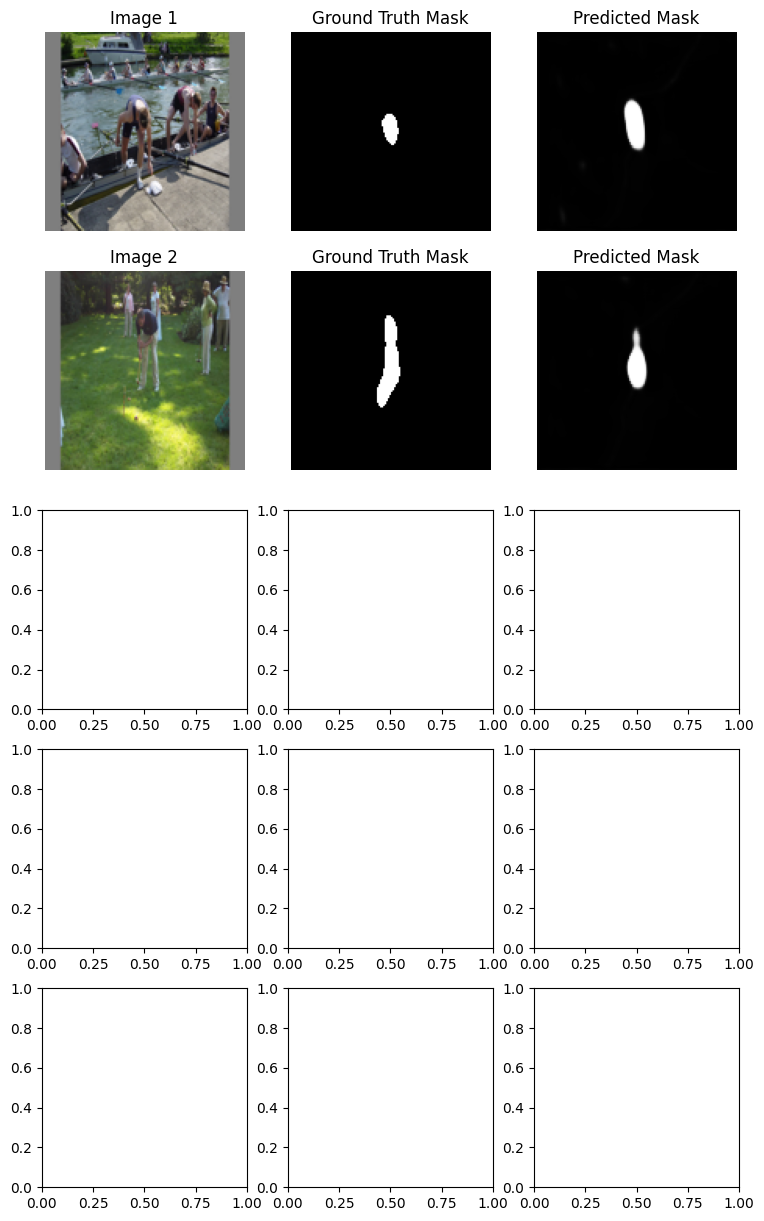

In [32]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to create a mask from predicted values
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

rows = 5
dataset_samples = dataset_test

# Set up the subplots
fig, axs = plt.subplots(rows, 3, figsize=(9, rows*3))

for i, (image, mask, filepath) in enumerate(dataset_samples):
    # Assuming `model` is already defined and trained
    pred_mask = model.predict(image)
    pred_mask_np = create_mask(pred_mask).numpy()

    image_path = filepath[0].numpy().decode('utf-8')
    # Load the image using PIL (Python Imaging Library)
    img = Image.open(image_path)
    target_size=(SIZE_X,SIZE_Y)
    # Resize the image
    img = img.resize(target_size)
    row = i % rows
    axs[row, 0].imshow(img)
    axs[row, 0].set_title(f'Image {i + 1}')
    axs[row, 0].axis('off')
    axs[row, 1].imshow(mask[0],cmap='gray')
    axs[row, 1].set_title('Ground Truth Mask')
    axs[row, 1].axis('off')
    axs[row, 2].imshow(pred_mask[0],cmap='gray')
    axs[row, 2].set_title('Predicted Mask')
    axs[row, 2].axis('off')

plt.show()


In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to create a confusion matrix
def create_confusion_matrix(model, dataset):
    true_labels = []
    predicted_labels = []
    for images, masks, _ in dataset:
        # Get model predictions
        predictions = model.predict(images)
        # Append flattened masks and predictions to the lists
        true_labels.append(tf.reshape(masks, [-1]).numpy())
        predicted_labels.append(tf.reshape(predictions, [-1]).numpy())
    # Concatenate the lists to create NumPy arrays
    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)
    # Use vectorized operations to create confusion matrix
    threshold = 0.5
    true_labels_binary = (true_labels > threshold).astype(int)
    predicted_labels_binary = (predicted_labels > threshold).astype(int)
    cm = confusion_matrix(true_labels_binary, predicted_labels_binary)
    return cm
# Get confusion matrix for dataset_test
confusion_mat = create_confusion_matrix(model, dataset_test)

1/1 [==============================] - 0s 244ms/step


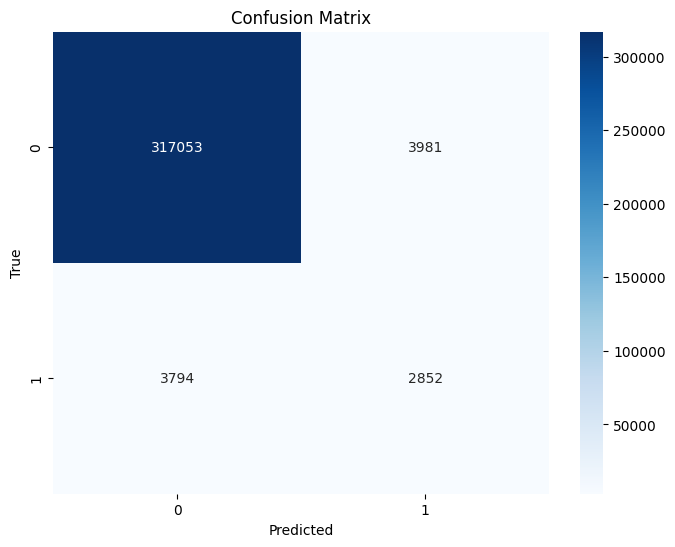


Trained Model Results:
Accuracy: 98%
Precision:  42%
Recall:  43%
F1 Score: 42%


In [31]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Extract true positives, true negatives, false positives, and false negatives from the confusion matrix
tn, fp, fn, tp = confusion_mat.ravel()
# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # To avoid division by zero
recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # To avoid division by zero
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # To avoid division by zero
print('\nTrained Model Results:')
print(f"Accuracy: {round(accuracy*100)}%")
print(f"Precision:  {round(precision*100)}%")
print(f"Recall:  {round(recall*100)}%")
print(f"F1 Score: {round(f1*100)}%")